In [1]:
!pip3 install xgboost

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# IMPORTANDO LIBRERÍAS

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.plotly as py

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

from itertools import product
import itertools
from collections import OrderedDict
import operator
import re
from math import sqrt
import pickle

# DATAFRAME

In [4]:
fifasup=pd.read_csv('prediction.csv')
fifasup.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,158023,L. Messi,RF,31,173.727522,72.137028,Left,4.0,Argentina,America,...,64,61,61,61,64,59,47,47,47,59
1,20801,Cristiano Ronaldo,ST,33,188.966778,83.025636,Right,4.0,Portugal,Europe,...,65,61,61,61,65,61,53,53,53,61
2,190871,Neymar Jr,LW,26,179.823225,68.053800,Right,5.0,Brazil,America,...,65,60,60,60,65,60,47,47,47,60
3,193080,De Gea,GK,27,195.062481,76.220256,Right,3.0,Spain,Europe,...,50,50,50,50,50,50,50,50,50,50
4,192985,K. De Bruyne,RCM,27,155.745200,69.868568,Right,5.0,Belgium,Europe,...,77,77,77,77,77,73,66,66,66,73


# AGRUPACIÓN DE DATOS

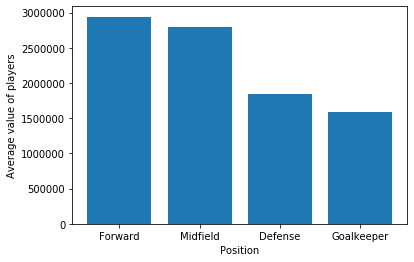

In [5]:
#Player value per position
positions = {
    'Forward' : ['CF', 'LF', 'LS', 'LW', 'RF', 'RS', 'RW', 'ST'],
    'Midfield' : ['CAM', 'CDM', 'CM', 'LAM', 'LCM', 'LDM', 'LM', 'RAM', 'RCB', 'RCM', 'RDM', 'RM'],
    'Defense' : ['CB', 'LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB'],
    'Goalkeeper' : ['GK'],
}
count_position = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}
players_position = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}
position_avg = {'Forward': 0, 'Midfield': 0, 'Defense': 0, 'Goalkeeper': 0}

def add_values(series):
    already_counted = [0, 0, 0, 0]
    preferred_position_list = re.sub("[^\w]", " ",  series[0]).split() #Split the preferred positions
    value = series[1]

    #Count the players per position category
    index = 0
    for preferred_position in preferred_position_list:
        for position in positions:
            if preferred_position in positions[position]:
                if(not already_counted[index]):
                    count_position[position] += value
                    players_position[position] += 1                    
                    already_counted[index] = 1
                    
position_value = fifasup[['Position', 'Value(€M)']]
position_value.apply(add_values, 1)

#Average the players value per position category
for position in count_position:
    position_avg[position] = count_position[position] / players_position[position]

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.bar(range(len(position_avg)), list(position_avg.values()))
plt.xticks(range(len(position_avg)), list(position_avg.keys()))
plt.xlabel('Position')
plt.ylabel('Average value of players')
plt.show()

Como podemos observar, las posiciones con mayor cantidad de jugadores son **Delanteros** y **Mediocampistas**.

# MODELOS PREDICTIVOS

Estableceremos un modelo de machine learning para intentar predecir el **valor de mercado** de una jugadora y el **salario** que debería de recibir con base en sus características individuales.

Es importante mencionar que la **nacionalidad** y el **club** son variables que por sí solas genera una brecha salarial y mercado.

In [6]:
fifasup_mach = fifasup.copy()
fifasup_mach = fifasup_mach.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifasup_mach = fifasup_mach.drop(fifasup_mach.columns[0], axis = 1)

In [7]:
fifasup_mach.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 74 columns):
Position              18207 non-null object
Age                   18207 non-null int64
Height(cm)            18207 non-null float64
Weight(kgs)           18207 non-null float64
Weak Foot             18207 non-null float64
Inter_Rep             18207 non-null float64
Overall               18207 non-null int64
Potential             18207 non-null int64
Difference            18207 non-null int64
Value(€M)             18207 non-null float64
Wage(€K)              18207 non-null float64
Release_Clause(€M)    18207 non-null float64
Special               18207 non-null int64
SkillMoves            18207 non-null float64
ShortPass             18207 non-null float64
LongPass              18207 non-null float64
ShotPower             18207 non-null float64
LongShots             18207 non-null float64
Penalties             18207 non-null float64
Agility               18207 non-null float64
Ac

In [8]:
fifaw_value=pd.read_csv('wdata.csv')
fifaw_value.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,190101,Samantha Kerr,ST,26,167,55,Right,4,Australia,Oceania,...,61,74,57,82,26,76,51,57,99,32
1,190102,Megan Rapinoe,CM,34,170,60,Right,4,USA,America,...,64,61,61,61,64,59,47,47,47,59
2,190103,Eugénie Le Sommer,ST,30,161,58,Right,5,France,Europe,...,9,95,11,77,31,76,28,23,85,64
3,190104,Lieke Martens,CM,26,170,66,Right,4,Netherlands,Europe,...,70,67,67,67,70,67,61,61,61,67
4,190105,Alex Morgan,ST,40,170,62,Left,4,USA,America,...,60,58,58,58,60,57,54,54,54,57


In [9]:
fifaw_value = fifaw_value.copy()
fifaw_value = fifaw_value.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifaw_value = fifaw_value.drop(fifaw_value.columns[0], axis = 1)

In [10]:
fifaw_wage=pd.read_csv('wdata.csv')
fifaw_wage.head()

,ID,Name,Position,Age,Height(cm),Weight(kgs),Preferred Foot,Weak Foot,Nationality,Continent,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,190101,Samantha Kerr,ST,26,167,55,Right,4,Australia,Oceania,...,61,74,57,82,26,76,51,57,99,32
1,190102,Megan Rapinoe,CM,34,170,60,Right,4,USA,America,...,64,61,61,61,64,59,47,47,47,59
2,190103,Eugénie Le Sommer,ST,30,161,58,Right,5,France,Europe,...,9,95,11,77,31,76,28,23,85,64
3,190104,Lieke Martens,CM,26,170,66,Right,4,Netherlands,Europe,...,70,67,67,67,70,67,61,61,61,67
4,190105,Alex Morgan,ST,40,170,62,Left,4,USA,America,...,60,58,58,58,60,57,54,54,54,57


In [11]:
fifaw_wage = fifaw_wage.copy()
fifaw_wage = fifaw_wage.drop(['Name', 'Nationality', 'Club','Work Rate','Work RAttack',
                                 'Work RDefense','Contract_Expiry','Preferred Foot', 'Joined',
                                 'Evolution', 'Continent', 'year_joined', 'month_joined',
                                 'day_joined', 'Jersey'], axis = 1)
fifaw_wage = fifaw_wage.drop(fifaw_wage.columns[0], axis = 1)

In [12]:
y_valuew = fifaw_value['Value(€M)'].copy()
fifaw_value = fifaw_value.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [13]:
y_wagew = fifaw_wage['Wage(€K)'].copy()
fifaw_wage = fifaw_wage.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [14]:
y_value = fifasup_mach['Value(€M)'].copy()
y_wage = fifasup_mach['Wage(€K)'].copy()
fifasup_mach = fifasup_mach.drop(['Value(€M)', 'Wage(€K)'], axis = 1)

In [15]:
def count_positions(position):
    return len(re.sub("[^\w]", " ",  position).split())

In [16]:
fifasup_mach['Versatility'] = fifasup_mach['Position'].apply(count_positions)
fifasup_mach.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,RF,31,173.727522,72.137028,4.0,5.0,94,94,0,226500000.0,...,61,61,61,64,59,47,47,47,59,1
1,ST,33,188.966778,83.025636,4.0,5.0,94,94,0,127100000.0,...,61,61,61,65,61,53,53,53,61,1
2,LW,26,179.823225,68.053800,5.0,5.0,92,93,1,228100000.0,...,60,60,60,65,60,47,47,47,60,1
3,GK,27,195.062481,76.220256,3.0,4.0,91,93,2,138600000.0,...,50,50,50,50,50,50,50,50,50,1
4,RCM,27,155.745200,69.868568,5.0,4.0,91,92,1,196400000.0,...,77,77,77,77,73,66,66,66,73,1


In [17]:
fifaw_value['Versatility'] = fifaw_value['Position'].apply(count_positions)
fifaw_value.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,ST,26,167,55,4,4,92,95,3,200000,...,74,57,82,26,76,51,57,99,32,1
1,CM,34,170,60,4,5,92,92,0,200000,...,61,61,61,64,59,47,47,47,59,1
2,ST,30,161,58,5,3,91,91,2,200000,...,95,11,77,31,76,28,23,85,64,1
3,CM,26,170,66,4,4,90,91,1,200000,...,67,67,67,70,67,61,61,61,67,1
4,ST,40,170,62,4,3,90,92,2,200000,...,58,58,58,60,57,54,54,54,57,1


In [18]:
fifaw_wage['Versatility'] = fifaw_wage['Position'].apply(count_positions)
fifaw_wage.head()

,Position,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
0,ST,26,167,55,4,4,92,95,3,200000,...,74,57,82,26,76,51,57,99,32,1
1,CM,34,170,60,4,5,92,92,0,200000,...,61,61,61,64,59,47,47,47,59,1
2,ST,30,161,58,5,3,91,91,2,200000,...,95,11,77,31,76,28,23,85,64,1
3,CM,26,170,66,4,4,90,91,1,200000,...,67,67,67,70,67,61,61,61,67,1
4,ST,40,170,62,4,3,90,92,2,200000,...,58,58,58,60,57,54,54,54,57,1


In [19]:
fifasup_mach['Versatility'].unique()

array([1])

In [20]:
fifasup_mach = fifasup_mach.drop(['Position'], axis = 1)

In [21]:
fifaw_value = fifaw_value.drop(['Position'], axis = 1)

In [22]:
fifaw_wage = fifaw_wage.drop(['Position'], axis = 1)

**Boosting** aplica un proceso iterativo donde en lugar de entrenar a todos los modelos de forma aislada cada nuevo modelo se entrena para corregir los errores cometidos por los anteriores. Es decir, los modelos se van agregando de forma secuencialmente hasta que no se puedan realizar más mejoras.

Empezaremos por crear un train-test-split donde el entrenamiento tome el 80% de los datos y el test el restante 20%.

**XGBoost** requiere que la información se presente de una forma particular denominada **DMatrix**. Es una transformación linear de los datos, pero es requerida.

Los parámetros más simples son **max_depth** (profundidad máxima de los árboles de decisión que se están entrenando), **objective** (la función de pérdida utilizada) y **num_class** (el número de clases en el conjunto de datos). El parámetro **eta** tiene una interpretación especial.


**Gradient Boosting** implica crear y agregar árboles de decisión a un modelo de conjunto secuencialmente. Se crean nuevos árboles para corregir los errores residuales en las predicciones del conjunto existente. Tener varios modelos juntos para formar uno muy grande y complicado puede generar que esta técnica sea propensa al **overfitting**. El parámetro **eta** nos permite evitar este problema, ya que se puede considerarlo como una tasa de aprendizaje. 

En lugar de simplemente agregar las predicciones de nuevos árboles al conjunto con todo el peso, el eta se multiplicará por los residuos que se agregan para reducir su peso. Esto reduce efectivamente la complejidad del modelo general.

Es común tener valores pequeños en el rango de **0.1 a 0.3**. La menor ponderación de estos residuos todavía nos ayudará a entrenar un modelo poderoso, pero no permitirá que ese modelo se escape a una complejidad profunda donde es más probable que ocurra un **overfitting**.

La información para adaptar mi modelo https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f 

# MODELO 1: Predicción del valor de mercado

In [23]:
#X_train_value, X_test_value, y_train_value, y_test_value = train_test_split(fifasup_mach, y_value, test_size=0.2)

In [24]:
#num_boost_round = 999
#early_stopping_rounds = 10

#xgb_params = {
#                'n_estimators':[500],
#                'objective':['reg:linear'],
#                'eval_metric':[ ["rmse" ,"mae"]],
#                'min_child_weight': [1],
#                'eta': [0.01, 0.1], 
#                'gamma': [0.05, 0.1],  
#                'subsample': [0.8, 1.0],
#                'colsample_bytree': [0.8, 1.0],
#               'max_depth': [6, 9]
#              }

params_perms = [dict(zip(xgb_params, v)) for v in product(*xgb_params.values())]
print(len(params_perms))
print(params_perms[0])

32
{'n_estimators': 500, 'objective': 'reg:linear', 'eval_metric': ['rmse', 'mae'], 'min_child_weight': 1, 'eta': 0.01, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 6}


In [25]:
dtrain_value = xgb.DMatrix(X_train_value, label=y_train_value)
dtest_value = xgb.DMatrix(X_test_value, label=y_test_value)
evaluation_set_value = [(dtest_value, "Test_set")]

In [26]:
mean_train_value = np.mean(y_train_value)

baseline_predictions_value = np.ones(y_test_value.shape) * mean_train_value

mae_baseline_value = mean_absolute_error(y_test_value, baseline_predictions_value)

rmse_baseline_value = sqrt(mean_squared_error(y_test_value, baseline_predictions_value))

print("Baseline MAE is {:.2f}".format(mae_baseline_value))
print("Baseline RMSE is {:.2f}".format(rmse_baseline_value))

Baseline MAE is 2831633.35
Baseline RMSE is 6245358.43


In [27]:
best_score_value = mae_baseline_value
best_params_value = {}
for i, grid_search_value in enumerate(params_perms):
    print("Permutation number:", i+1)
    cv_results_value = xgb.cv(grid_search_value,
                        dtrain_value,
                       num_boost_round=num_boost_round,
                      seed=42,
                     nfold=2,
                    metrics=['mae', 'rmse'],
                   early_stopping_rounds=early_stopping_rounds
                  )
    
    mean_mae_value = cv_results_value['test-mae-mean'].min()
    boost_rounds_value = cv_results_value['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae_value, boost_rounds_value))
    if mean_mae_value < best_score_value:
        best_score_value = mean_mae_value
        best_params_value = grid_search_value

Permutation number: 1
[08:55:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 183339.609375 for 998 rounds
Permutation number: 2
[08:56:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 173543.625 for 998 rounds
Permutation number: 3
[08:58:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 186940.0390625 for 998 rounds
Permutation number: 4
[08:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


	MAE 189489.1796875 for 174 rounds
Permutation number: 30
[10:03:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 181328.296875 for 180 rounds
Permutation number: 31
[10:03:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:03:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 187977.90625 for 180 rounds
Permutation number: 32
[10:04:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:04:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 178214.0546875 for 270 rounds


In [28]:
print("Best Score:", best_score_value)
print("Best Parameters:", best_params_value)

Best Score: 173299.171875
Best Parameters: {'n_estimators': 500, 'objective': 'reg:linear', 'eval_metric': ['rmse', 'mae'], 'min_child_weight': 1, 'eta': 0.01, 'gamma': 0.05, 'subsample': 0.8, 'colsample_bytree': 1.0, 'max_depth': 9}


In [30]:
#Retrain a model with new best params
model_value = xgb.train(
    best_params_value,
    dtrain_value,
    num_boost_round=num_boost_round,
    evals=evaluation_set_value,
    early_stopping_rounds=early_stopping_rounds
 )

[10:06:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test_set-rmse:6.66503e+06	Test_set-mae:2.47645e+06
Multiple eval metrics have been passed: 'Test_set-mae' will be used for early stopping.

Will train until Test_set-mae hasn't improved in 10 rounds.
[1]	Test_set-rmse:6.60355e+06	Test_set-mae:2.45206e+06
[2]	Test_set-rmse:6.5437e+06	Test_set-mae:2.42825e+06
[3]	Test_set-rmse:6.48461e+06	Test_set-mae:2.40476e+06
[4]	Test_set-rmse:6.42579e+06	Test_set-mae:2.38137e+06
[5]	Test_set-rmse:6.36778e+06	Test_set-mae:2.35836e+06
[6]	Test_set-rmse:6.30991e+06	Test_set-mae:2.33544e+06
[7]	Test_set-rmse:6.25284e+06	Test_set-mae:2.313e+06
[8]	Test_set-rmse:6.1962e+06	Test_set-mae:2.29061e+06
[9]	Test_set-rmse:6.14019e+06	Test_set-mae:2.26851e+06
[10]	Test_set-rmse:6.08456e+06	Test_set-mae:2.24659e+06
[11]	Test_set-rmse:6.02861e+06	Test_set-mae:2.22478e+06
[12]	Test_set-rmse:5.97342e+06	Test_set-mae:2.20312e+06
[13]	Test_set-rmse:5.

[146]	Test_set-rmse:2.01585e+06	Test_set-mae:628498
[147]	Test_set-rmse:2.00205e+06	Test_set-mae:622915
[148]	Test_set-rmse:1.98888e+06	Test_set-mae:617460
[149]	Test_set-rmse:1.97654e+06	Test_set-mae:612180
[150]	Test_set-rmse:1.96524e+06	Test_set-mae:606952
[151]	Test_set-rmse:1.95298e+06	Test_set-mae:601597
[152]	Test_set-rmse:1.93964e+06	Test_set-mae:596276
[153]	Test_set-rmse:1.92664e+06	Test_set-mae:591086
[154]	Test_set-rmse:1.91415e+06	Test_set-mae:585854
[155]	Test_set-rmse:1.90257e+06	Test_set-mae:580727
[156]	Test_set-rmse:1.89013e+06	Test_set-mae:575613
[157]	Test_set-rmse:1.87711e+06	Test_set-mae:570500
[158]	Test_set-rmse:1.86452e+06	Test_set-mae:565399
[159]	Test_set-rmse:1.85224e+06	Test_set-mae:560494
[160]	Test_set-rmse:1.8407e+06	Test_set-mae:555556
[161]	Test_set-rmse:1.82867e+06	Test_set-mae:550697
[162]	Test_set-rmse:1.8167e+06	Test_set-mae:545854
[163]	Test_set-rmse:1.80519e+06	Test_set-mae:541182
[164]	Test_set-rmse:1.79377e+06	Test_set-mae:536532
[165]	Test_set

[304]	Test_set-rmse:1.06208e+06	Test_set-mae:214968
[305]	Test_set-rmse:1.06063e+06	Test_set-mae:214229
[306]	Test_set-rmse:1.05886e+06	Test_set-mae:213491
[307]	Test_set-rmse:1.05708e+06	Test_set-mae:212810
[308]	Test_set-rmse:1.05434e+06	Test_set-mae:212099
[309]	Test_set-rmse:1.053e+06	Test_set-mae:211389
[310]	Test_set-rmse:1.0509e+06	Test_set-mae:210687
[311]	Test_set-rmse:1.04807e+06	Test_set-mae:209999
[312]	Test_set-rmse:1.04697e+06	Test_set-mae:209389
[313]	Test_set-rmse:1.04586e+06	Test_set-mae:208782
[314]	Test_set-rmse:1.04488e+06	Test_set-mae:208208
[315]	Test_set-rmse:1.04306e+06	Test_set-mae:207615
[316]	Test_set-rmse:1.04037e+06	Test_set-mae:206979
[317]	Test_set-rmse:1.03941e+06	Test_set-mae:206486
[318]	Test_set-rmse:1.03756e+06	Test_set-mae:205877
[319]	Test_set-rmse:1.03502e+06	Test_set-mae:205273
[320]	Test_set-rmse:1.03237e+06	Test_set-mae:204651
[321]	Test_set-rmse:1.02993e+06	Test_set-mae:204082
[322]	Test_set-rmse:1.02914e+06	Test_set-mae:203560
[323]	Test_set-

[475]	Test_set-rmse:907446	Test_set-mae:173620
[476]	Test_set-rmse:907150	Test_set-mae:173575
[477]	Test_set-rmse:906804	Test_set-mae:173548
[478]	Test_set-rmse:906475	Test_set-mae:173491
[479]	Test_set-rmse:906249	Test_set-mae:173446
[480]	Test_set-rmse:906059	Test_set-mae:173370
[481]	Test_set-rmse:905756	Test_set-mae:173317
[482]	Test_set-rmse:905742	Test_set-mae:173311
[483]	Test_set-rmse:905484	Test_set-mae:173270
[484]	Test_set-rmse:905228	Test_set-mae:173230
[485]	Test_set-rmse:905059	Test_set-mae:173182
[486]	Test_set-rmse:904909	Test_set-mae:173142
[487]	Test_set-rmse:904738	Test_set-mae:173093
[488]	Test_set-rmse:904505	Test_set-mae:173060
[489]	Test_set-rmse:904266	Test_set-mae:173014
[490]	Test_set-rmse:903993	Test_set-mae:172961
[491]	Test_set-rmse:903766	Test_set-mae:172918
[492]	Test_set-rmse:903484	Test_set-mae:172866
[493]	Test_set-rmse:903239	Test_set-mae:172810
[494]	Test_set-rmse:903083	Test_set-mae:172789
[495]	Test_set-rmse:902913	Test_set-mae:172755
[496]	Test_se

[650]	Test_set-rmse:866546	Test_set-mae:169362
[651]	Test_set-rmse:866213	Test_set-mae:169348
[652]	Test_set-rmse:866216	Test_set-mae:169347
[653]	Test_set-rmse:865807	Test_set-mae:169328
[654]	Test_set-rmse:865674	Test_set-mae:169299
[655]	Test_set-rmse:865634	Test_set-mae:169297
[656]	Test_set-rmse:865376	Test_set-mae:169289
[657]	Test_set-rmse:865120	Test_set-mae:169285
[658]	Test_set-rmse:864846	Test_set-mae:169276
[659]	Test_set-rmse:864441	Test_set-mae:169253
[660]	Test_set-rmse:864136	Test_set-mae:169224
[661]	Test_set-rmse:863823	Test_set-mae:169204
[662]	Test_set-rmse:863696	Test_set-mae:169186
[663]	Test_set-rmse:863640	Test_set-mae:169178
[664]	Test_set-rmse:863391	Test_set-mae:169168
[665]	Test_set-rmse:862906	Test_set-mae:169122
[666]	Test_set-rmse:862609	Test_set-mae:169107
[667]	Test_set-rmse:862494	Test_set-mae:169090
[668]	Test_set-rmse:862251	Test_set-mae:169067
[669]	Test_set-rmse:862175	Test_set-mae:169067
[670]	Test_set-rmse:861765	Test_set-mae:169046
[671]	Test_se

[825]	Test_set-rmse:836232	Test_set-mae:167435
[826]	Test_set-rmse:836196	Test_set-mae:167430
[827]	Test_set-rmse:836030	Test_set-mae:167416
[828]	Test_set-rmse:835894	Test_set-mae:167407
[829]	Test_set-rmse:835890	Test_set-mae:167408
[830]	Test_set-rmse:835757	Test_set-mae:167394
[831]	Test_set-rmse:835601	Test_set-mae:167385
[832]	Test_set-rmse:835481	Test_set-mae:167379
[833]	Test_set-rmse:835332	Test_set-mae:167360
[834]	Test_set-rmse:835298	Test_set-mae:167359
[835]	Test_set-rmse:835160	Test_set-mae:167343
[836]	Test_set-rmse:835010	Test_set-mae:167333
[837]	Test_set-rmse:834896	Test_set-mae:167337
[838]	Test_set-rmse:834674	Test_set-mae:167318
[839]	Test_set-rmse:834659	Test_set-mae:167313
[840]	Test_set-rmse:834648	Test_set-mae:167308
[841]	Test_set-rmse:834451	Test_set-mae:167295
[842]	Test_set-rmse:834306	Test_set-mae:167280
[843]	Test_set-rmse:834301	Test_set-mae:167262
[844]	Test_set-rmse:834183	Test_set-mae:167252
[845]	Test_set-rmse:833981	Test_set-mae:167244
[846]	Test_se

In [31]:
#print("Average guess error", mae_baseline_value)
#print("vs Mean Absolute Error", mean_absolute_error(model_value.predict(dtest_value), y_test_value))

Average guess error 2831633.3477737037
vs Mean Absolute Error 166048.70844166153


In [32]:
#!#Predict the value based on the model.
#dpred_value = xgb.DMatrix(fifasup_mach, label = y_value)
#y_pred = pd.Series(model_value.predict(dpred_value))

In [67]:
#!#Top 10% players with overpriced transfer values.
sub_value = y_value.subtract(y_pred)
exp_value = fifasup_mach.loc[sub_value.nlargest(int(len(sub_value)/1000)).index]
exp_value

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
2,26,179.823225,68.053800,5.0,5.0,92,93,1,228100000.0,2143,...,60,60,60,65,60,47,47,47,60,1
4,27,155.745200,69.868568,5.0,4.0,91,92,1,196400000.0,2281,...,77,77,77,77,73,66,66,66,73,1
91,29,182.871076,71.229644,3.0,3.0,85,85,0,200000.0,2245,...,81,81,81,78,78,80,80,80,78,1
176,24,179.823225,78.035024,4.0,3.0,83,89,6,200000.0,2115,...,78,78,78,76,74,69,69,69,74,1
43,25,155.745200,74.859180,4.0,3.0,87,90,3,114500000.0,1940,...,53,53,53,54,52,51,51,51,52,1
34,29,192.014630,92.099476,3.0,4.0,88,88,0,75900000.0,2038,...,83,83,83,78,80,85,85,85,80,1
44,27,188.966778,88.923632,3.0,3.0,87,90,3,90500000.0,1660,...,75,75,75,71,75,84,84,84,75,1
10,29,182.871076,79.849792,4.0,4.0,90,90,0,127100000.0,2152,...,62,62,62,61,58,57,57,57,58,1
22,32,195.062481,92.099476,4.0,5.0,89,89,0,62700000.0,1473,...,50,50,50,50,50,50,50,50,50,1
323,21,155.745200,69.868568,3.0,1.0,81,89,8,41600000.0,2064,...,78,78,78,77,75,72,72,72,75,1


In [68]:
#Top 10% players with underpriced transfer values.
cheap_value = sub_value.nsmallest(int(len(sub_value)/1000))
cheap_value = fifasup_mach.loc[cheap_value.index]
cheap_value

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
452,24,155.745200,74.859180,4.0,2.0,80,85,5,200000.0,2122,...,77,77,77,75,74,72,72,72,74,1
32,26,176.775373,68.053800,4.0,3.0,88,89,1,147700000.0,2175,...,70,70,70,71,67,58,58,58,67,1
997,25,182.871076,73.951796,3.0,1.0,77,80,3,200000.0,2041,...,75,75,75,75,74,70,70,70,74,1
677,29,155.440415,69.868568,3.0,2.0,79,79,0,200000.0,2038,...,75,75,75,78,78,73,73,73,78,1
11,28,182.871076,76.220256,5.0,4.0,90,90,0,156800000.0,2190,...,82,82,82,79,77,72,72,72,77,1
713,33,176.775373,74.859180,4.0,3.0,79,79,0,17200000.0,2070,...,60,60,60,62,59,53,53,53,59,1
1902,26,170.679671,60.794728,4.0,1.0,75,75,0,200000.0,1849,...,57,57,57,60,57,48,48,48,57,1
49,29,173.727522,68.053800,3.0,3.0,87,87,0,77900000.0,2230,...,80,80,80,84,84,78,78,78,84,1
2399,26,155.440415,74.859180,4.0,1.0,74,74,0,200000.0,1938,...,55,55,55,59,56,48,48,48,56,1
83,23,182.871076,77.127640,4.0,3.0,85,90,5,107300000.0,2196,...,80,80,80,78,78,78,78,78,78,1


In [35]:
#model_value.save_model("model_value.model")

In [36]:
#fifasup_mach.columns

Index(['Age', 'Height(cm)', 'Weight(kgs)', 'Weak Foot', 'Inter_Rep', 'Overall',
       'Potential', 'Difference', 'Release_Clause(€M)', 'Special',
       'SkillMoves', 'ShortPass', 'LongPass', 'ShotPower', 'LongShots',
       'Penalties', 'Agility', 'Acceleration', 'SprintSpeed', 'Stamina',
       'Strength', 'Reactions', 'Dribbling', 'BallControl', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Balance', 'Composure',
       'Crossing', 'Finishing', 'Jumping', 'HeadAccuracy', 'Marking',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'Volleys', 'Curve',
       'FKAccuracy', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Versatility'],
      dtype='object')

In [37]:
#fifaw_value.shape

(15, 72)

In [38]:
#loaded_modelv = xgb.Booster()
#loaded_modelv.load_model("model_value.model")

[10:09:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [39]:
#fifaw_value['Value(€M)'] = loaded_modelv.predict(xgb.DMatrix(fifaw_value))

In [40]:
#exchange_rate = 21.1473

In [41]:
#fifaw_value['Value($M)'] = fifaw_value['Value(€M)'] * exchange_rate

In [69]:
fifaw_value

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility,Value(€M),Value($M)
Name,,,,,,,,,,,,,,,,,,,,,
Samantha Kerr,26,167,55,4,4,92,95,3,200000,1598,...,82,26,76,51,57,99,32,1,39506032.0,8.354460e+08
Megan Rapinoe,34,170,60,4,5,92,92,0,200000,2202,...,61,64,59,47,47,47,59,1,42657360.0,9.020880e+08
Eugénie Le Sommer,30,161,58,5,3,91,91,2,200000,1598,...,77,31,76,28,23,85,64,1,45545900.0,9.631729e+08
Lieke Martens,26,170,66,4,4,90,91,1,200000,2246,...,67,70,67,61,61,61,67,1,52543788.0,1.111159e+09
Alex Morgan,40,170,62,4,3,90,92,2,200000,2031,...,58,60,57,54,54,54,57,1,33040556.0,6.987186e+08
Mana Iwabuchi,26,156,52,5,2,88,91,3,200000,1598,...,75,64,43,77,31,11,98,1,37385208.0,7.905962e+08
Kenti Robles,28,160,55,2,3,82,82,0,200000,2154,...,83,78,77,81,81,81,77,1,16133888.0,3.411882e+08
Charlyn Corral,28,152,52,4,4,82,84,2,200000,1926,...,53,59,54,42,42,42,54,1,21295090.0,4.503337e+08
Kosovare Asllani,30,166,57,4,3,83,83,0,200000,1598,...,90,96,60,32,30,36,40,1,22460770.0,4.749847e+08


# MODELO 2: Predicción del salario

In [43]:
#X_train_wage, X_test_wage, y_train_wage, y_test_wage = train_test_split(fifasup_mach, y_wage, test_size=0.2)

In [44]:
#dtrain_wage = xgb.DMatrix(X_train_wage, label=y_train_wage)
#dtest_wage = xgb.DMatrix(X_test_wage, label=y_test_wage)
#evaluation_set_wage = [(dtest_wage, "Test_set")]

In [45]:
#mean_train_wage = np.mean(y_train_wage)

#baseline_predictions_wage = np.ones(y_test_wage.shape) * mean_train_wage

#mae_baseline_wage = mean_absolute_error(y_test_wage, baseline_predictions_wage)

#rmse_baseline_wage = sqrt(mean_squared_error(y_test_wage, baseline_predictions_wage))

#print("Baseline MAE is {:.2f}".format(mae_baseline_wage))
#print("Baseline RMSE is {:.2f}".format(rmse_baseline_wage))

Baseline MAE is 14535.36
Baseline RMSE is 32249.61


In [46]:
#best_score_wage = mae_baseline_wage
#best_params_wage = {}
#for i, grid_search_wage in enumerate(params_perms):
#    print("Permutation number:", i+1)
#    cv_results_wage = xgb.cv(grid_search_wage,
#                        dtrain_wage,
#                        num_boost_round=num_boost_round,
#                        seed=42,
#                        nfold=2,
#                        metrics=['mae', 'rmse'],
#                        early_stopping_rounds=early_stopping_rounds
#                        )
    
#    mean_mae_wage = cv_results_wage['test-mae-mean'].min()
#    boost_rounds_wage = cv_results_wage['test-mae-mean'].argmin()
#    print("\tMAE {} for {} rounds".format(mean_mae_wage, boost_rounds_wage))
#    if mean_mae_wage < best_score_wage:
#        best_score_wage = mean_mae_wage
#        best_params_wage = grid_search_wage

Permutation number: 1
[10:10:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7478.4387205 for 150 rounds
Permutation number: 2
[10:11:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:11:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7303.6918945 for 172 rounds
Permutation number: 3
[10:12:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7554.022217 for 162 rounds
Permutation number: 4
[10:14:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[1

	MAE 7574.373291 for 13 rounds
Permutation number: 30
[10:29:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7470.817383 for 16 rounds
Permutation number: 31
[10:29:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7592.4675295 for 15 rounds
Permutation number: 32
[10:29:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:29:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	MAE 7606.4104005 for 15 rounds


In [47]:
#!#Retrain a model with new best params
#model_wage = xgb.train(
#    best_params_wage,
#    dtrain_wage,
#    num_boost_round=num_boost_round,
#    evals=evaluation_set_wage,
#    early_stopping_rounds=early_stopping_rounds
#)#

[10:31:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test_set-rmse:34425.7	Test_set-mae:12456.8
Multiple eval metrics have been passed: 'Test_set-mae' will be used for early stopping.

Will train until Test_set-mae hasn't improved in 10 rounds.
[1]	Test_set-rmse:34238.6	Test_set-mae:12336.3
[2]	Test_set-rmse:34099.2	Test_set-mae:12226.5
[3]	Test_set-rmse:33972.9	Test_set-mae:12118.4
[4]	Test_set-rmse:33784.1	Test_set-mae:12011.3
[5]	Test_set-rmse:33609.3	Test_set-mae:11907.2
[6]	Test_set-rmse:33448.7	Test_set-mae:11806.5
[7]	Test_set-rmse:33322.3	Test_set-mae:11705.6
[8]	Test_set-rmse:33147.9	Test_set-mae:11606.6
[9]	Test_set-rmse:33025.5	Test_set-mae:11507.6
[10]	Test_set-rmse:32854.2	Test_set-mae:11414.3
[11]	Test_set-rmse:32694.3	Test_set-mae:11326.7
[12]	Test_set-rmse:32530.8	Test_set-mae:11239
[13]	Test_set-rmse:32386.5	Test_set-mae:11153.9
[14]	Test_set-rmse:32243.8	Test_set-mae:11071.3
[15]	Test_set-rmse:32129.9	

[165]	Test_set-rmse:22493.9	Test_set-mae:7356.78
[166]	Test_set-rmse:22480.6	Test_set-mae:7357.62
[167]	Test_set-rmse:22465.6	Test_set-mae:7354.52
[168]	Test_set-rmse:22446.5	Test_set-mae:7354.5
[169]	Test_set-rmse:22432.2	Test_set-mae:7352.35
[170]	Test_set-rmse:22407	Test_set-mae:7350
[171]	Test_set-rmse:22392.2	Test_set-mae:7347.46
[172]	Test_set-rmse:22369.6	Test_set-mae:7346.68
[173]	Test_set-rmse:22354.2	Test_set-mae:7347.86
[174]	Test_set-rmse:22341.6	Test_set-mae:7347.24
[175]	Test_set-rmse:22328.5	Test_set-mae:7346.55
[176]	Test_set-rmse:22312.6	Test_set-mae:7347.06
[177]	Test_set-rmse:22302	Test_set-mae:7347.06
[178]	Test_set-rmse:22289.2	Test_set-mae:7349.53
[179]	Test_set-rmse:22273.9	Test_set-mae:7348.36
[180]	Test_set-rmse:22260.4	Test_set-mae:7348.5
[181]	Test_set-rmse:22252.7	Test_set-mae:7349.64
[182]	Test_set-rmse:22234.6	Test_set-mae:7349.5
[183]	Test_set-rmse:22223.5	Test_set-mae:7349.3
[184]	Test_set-rmse:22203.5	Test_set-mae:7347.21
[185]	Test_set-rmse:22186.7	Tes

In [48]:
#print("Average guess error", mae_baseline_wage)
#print("vs Mean Absolute Error", mean_absolute_error(model_wage.predict(dtest_wage), y_test_wage))

Average guess error 14535.359641577184
vs Mean Absolute Error 7346.8963366303715


In [49]:
#!#Predict the value based on the model.
#dpred_wage = xgb.DMatrix(fifasup_mach, label = y_wage)
#y_pred_wage = pd.Series(model_wage.predict(dpred_wage))

In [50]:
#!#Top 10% players with overpriced wages.
sub_wage = y_value.subtract(y_pred_wage)
exp_wage = fifasup_mach.loc[sub_wage.nlargest(int(len(sub_wage)/1000)).index]
exp_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
2,26,179.823225,68.053800,5.0,5.0,92,93,1,228100000.0,2143,...,60,60,60,65,60,47,47,47,60,1
0,31,173.727522,72.137028,4.0,5.0,94,94,0,226500000.0,2202,...,61,61,61,64,59,47,47,47,59,1
4,27,155.745200,69.868568,5.0,4.0,91,92,1,196400000.0,2281,...,77,77,77,77,73,66,66,66,73,1
5,27,176.775373,73.951796,4.0,4.0,91,91,0,172100000.0,2142,...,63,63,63,66,60,49,49,49,60,1
15,24,155.440415,74.859180,3.0,3.0,89,94,5,153500000.0,2092,...,58,58,58,62,56,45,45,45,56,1
16,24,188.966778,88.923632,4.0,3.0,89,91,2,160700000.0,2165,...,66,66,66,65,62,60,60,60,62,1
25,19,155.440415,73.044412,4.0,3.0,88,95,7,166100000.0,2118,...,62,62,62,66,62,54,54,54,62,1
7,31,182.871076,86.201480,4.0,5.0,91,91,0,164000000.0,2346,...,68,68,68,69,66,63,63,63,66,1
17,27,179.823225,73.044412,3.0,4.0,89,90,1,165800000.0,2246,...,67,67,67,70,67,61,61,61,67,1
10,29,182.871076,79.849792,4.0,4.0,90,90,0,127100000.0,2152,...,62,62,62,61,58,57,57,57,58,1


In [51]:
#!#Top 10% players with underpriced transfer values.
cheap_wage = sub_wage.nsmallest(int(len(sub_wage)/1000))
cheap_wage = fifasup_mach.loc[cheap_wage.index]
cheap_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB,Versatility
16628,38,188.966778,79.849792,2.0,1.0,57,57,0,13000.0,1001,...,50,50,50,50,50,50,50,50,50,1
16310,36,188.966778,83.933020,2.0,1.0,57,57,0,18000.0,1117,...,50,50,50,50,50,50,50,50,50,1
17657,35,198.110332,78.942408,2.0,1.0,53,53,0,18000.0,1000,...,44,44,44,38,41,51,51,51,41,1
16596,40,182.871076,86.201480,3.0,1.0,57,57,0,17000.0,1066,...,50,50,50,50,50,50,50,50,50,1
17842,39,185.918927,73.951796,3.0,1.0,52,52,0,22000.0,1473,...,46,46,46,45,44,44,44,44,44,1
15426,41,182.871076,83.025636,3.0,1.0,59,59,0,18000.0,1031,...,50,50,50,50,50,50,50,50,50,1
17209,37,188.966778,78.942408,2.0,1.0,55,55,0,13000.0,823,...,50,50,50,50,50,50,50,50,50,1
15133,39,188.966778,88.923632,3.0,1.0,60,60,0,15000.0,942,...,50,50,50,50,50,50,50,50,50,1
17704,36,182.871076,78.035024,2.0,1.0,53,53,0,15000.0,867,...,50,50,50,50,50,50,50,50,50,1
16204,37,188.966778,88.016248,2.0,1.0,58,58,0,13000.0,1070,...,50,50,50,50,50,50,50,50,50,1


In [52]:
#model_wage.save_model("model_wage.model")

In [53]:
#loaded_modelw = xgb.Booster()
#loaded_modelw.load_model("model_wage.model")

[10:33:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [54]:
#fifaw_wage['Wage(€K)'] = loaded_modelw.predict(xgb.DMatrix(fifaw_wage))

In [55]:
#exchange_rate = 21.1473

In [56]:
#fifaw_wage['Wage($K)'] = (fifaw_wage['Wage(€K)'] * exchange_rate)/1000000

In [57]:
#fifaw_wage['WageM($K)'] = (fifaw_wage['Wage($K)']/12)*1000

In [58]:
#fifaw_wage

,Age,Height(cm),Weight(kgs),Weak Foot,Inter_Rep,Overall,Potential,Difference,Release_Clause(€M),Special,...,RWB,LB,LCB,CB,RCB,RB,Versatility,Wage(€K),Wage($K),WageM($K)
0,26,167,55,4,4,92,95,3,200000,1598,...,26,76,51,57,99,32,1,146650.406250,3.101260,258.438354
1,34,170,60,4,5,92,92,0,200000,2202,...,64,59,47,47,47,59,1,156428.562500,3.308042,275.670146
2,30,161,58,5,3,91,91,2,200000,1598,...,31,76,28,23,85,64,1,178536.906250,3.775574,314.631146
3,26,170,66,4,4,90,91,1,200000,2246,...,70,67,61,61,61,67,1,125084.164062,2.645192,220.432708
4,40,170,62,4,3,90,92,2,200000,2031,...,60,57,54,54,54,57,1,98450.859375,2.081970,173.497490
5,26,156,52,5,2,88,91,3,200000,1598,...,64,43,77,31,11,98,1,115076.148438,2.433550,202.795833
6,28,160,55,2,3,82,82,0,200000,2154,...,78,77,81,81,81,77,1,61430.449219,1.299088,108.257344
7,28,152,52,4,4,82,84,2,200000,1926,...,59,54,42,42,42,54,1,55289.703125,1.169228,97.435667
8,30,166,57,4,3,83,83,0,200000,1598,...,96,60,32,30,36,40,1,60763.574219,1.284986,107.082135
9,27,175,68,3,4,81,84,3,200000,1598,...,35,63,59,38,12,37,1,61746.792969,1.305778,108.814833


In [59]:
#df_names = pd.read_csv('wdata.csv')

In [60]:
#df_names = df_names[['Name']]

In [61]:
#fifaw_wage = fifaw_wage.join(df_names)

In [62]:
#fifaw_value = fifaw_value.join(df_names)

In [63]:
#fifaw_wage = fifaw_wage.set_index('Name')

In [70]:
fifaw_wage.to_csv('fifaw_wage_pred', encoding='utf-8', index=False)

In [65]:
#fifaw_value = fifaw_value.set_index('Name')

In [71]:
fifaw_value.to_csv('fifaw_value_pred', encoding='utf-8', index=False)